In [1]:
# automatically reload edited source code
%load_ext autoreload
%autoreload 2

# external package imports
import numpy as np
import pandas as pd
import os, pdb, glob, time, argparse
from os.path import exists, split, isdir, getsize
from sdo_clv_pipeline.sdo_plot import *

# internal package imports
from sdo_clv_pipeline.paths import root
from sdo_clv_pipeline.sdo_io import *
from sdo_clv_pipeline.sdo_process import *
from sdo_clv_pipeline.sdo_io import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# returns four sorted lists with the path to each of the file types
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
con_files, mag_files, dop_files, aia_files = find_data(data_dir, "2014")
print(con_files)
print(len(con_files))
# print(con_files)
# print(mag_files)
# print(dop_files)
# print(aia_files)

File counts:
CON: 10
MAG: 10
DOP: 10
AIA: 11
[datetime.datetime(2014, 1, 10, 0, 0), datetime.datetime(2014, 1, 3, 0, 0), datetime.datetime(2014, 1, 11, 0, 0), datetime.datetime(2014, 1, 5, 0, 0), datetime.datetime(2014, 1, 6, 0, 0), datetime.datetime(2014, 1, 4, 0, 0), datetime.datetime(2014, 1, 9, 0, 0), datetime.datetime(2014, 1, 7, 0, 0)]
['c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140103_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140104_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140105_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140106_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140107_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140109_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Docume

/Users/srugins/sdo-clv-pipeline/data
correct mag
correct dop
checking
set to nan
mask
About to construct SunMask
Entered SunMask.__init__


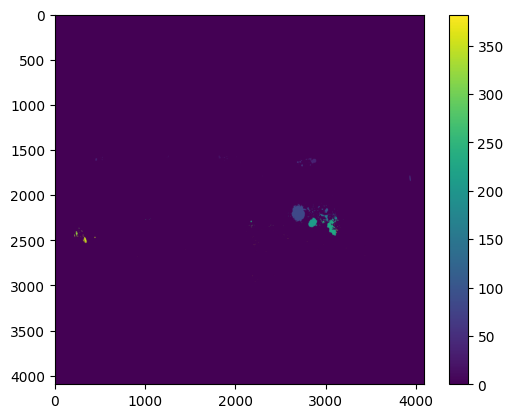

36
2763.0
83
20485.0
102
1140.0
157
2308.0
185
768.0
209
7125.0
229
9258.0
353
1253.0
trying to plot...
0.4964512
0.358708
0.5298573
0.5297886
0.5996394
0.4604378
0.5900764
1.1445833


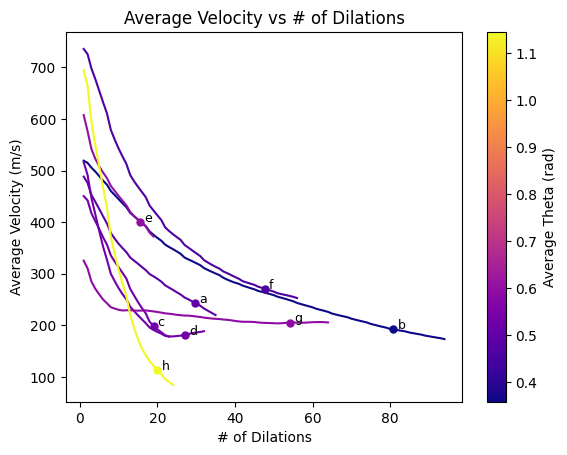

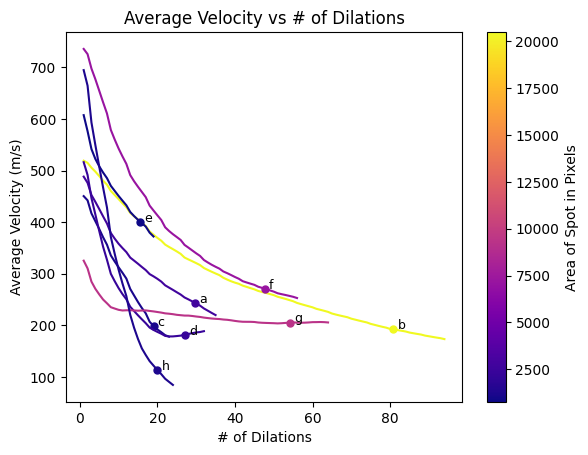

trying to plot...
0.4964512
0.358708
0.5298573
0.5297886
0.5996394
0.4604378
0.5900764
1.1445833


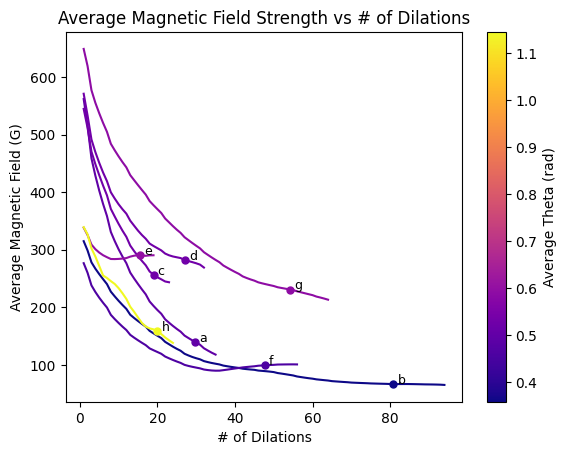

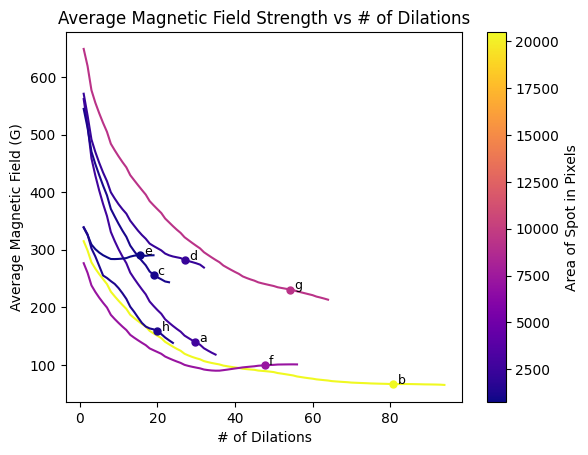

trying to plot...
0.4964512
0.358708
0.5298573
0.5297886
0.5996394
0.4604378
0.5900764
1.1445833


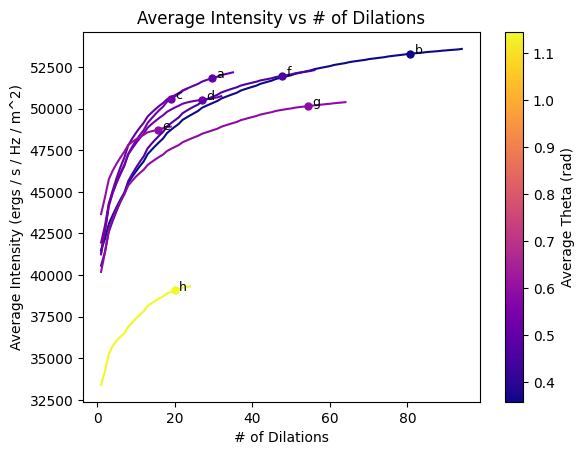

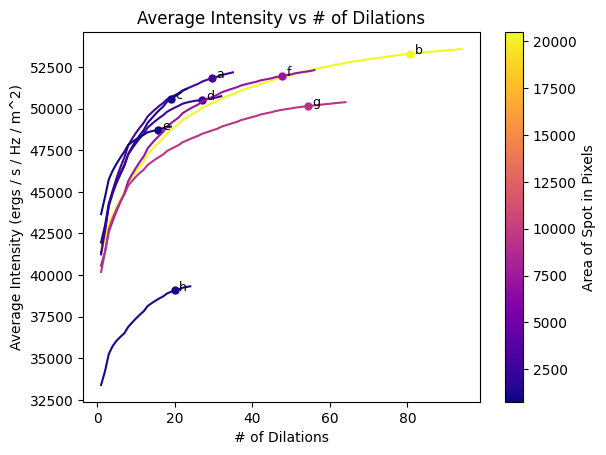

len moat pixels= 4096
shape moat pixels= (4096, 4096)
moat pixels
	 >>> Epoch 2014-01-06T00:00:00 run successfully
/Users/srugins/sdo-clv-pipeline/data
correct mag
correct dop
checking
set to nan
mask
About to construct SunMask
Entered SunMask.__init__


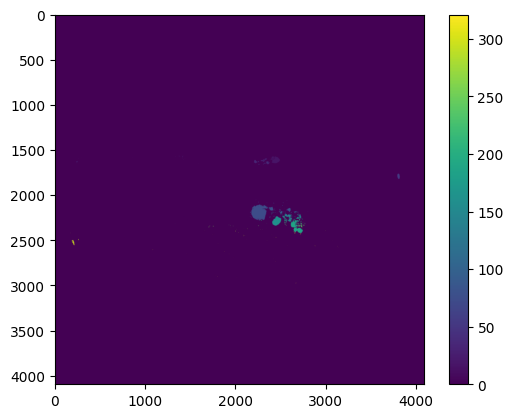

17
5278.0
34
811.0
40
759.0
55
1263.0
74
22953.0
80
1374.0
85
1112.0
145
3007.0
151
755.0
161
6942.0
187
8772.0
295
671.0
trying to plot...
0.31028044
0.23467857
0.2672806
1.1738589
0.14276329
0.19448027
0.2973504
0.30961758
0.37205675
0.25415817
0.37406388
1.3683301


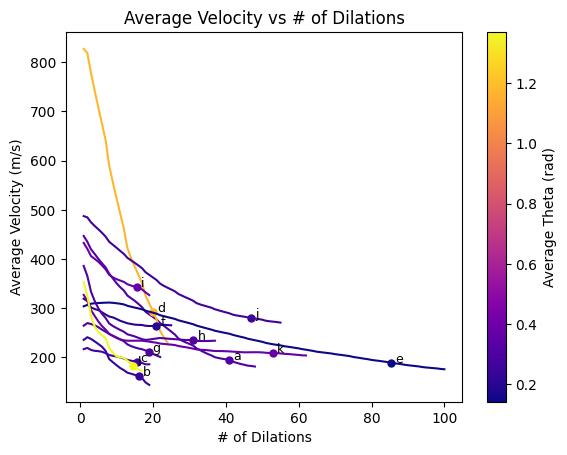

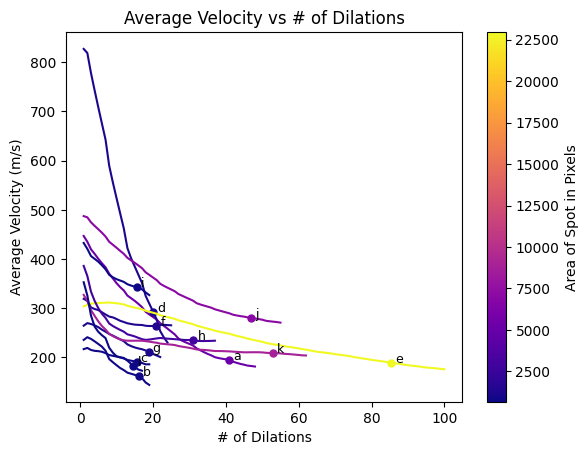

trying to plot...
0.31028044
0.23467857
0.2672806
1.1738589
0.14276329
0.19448027
0.2973504
0.30961758
0.37205675
0.25415817
0.37406388
1.3683301


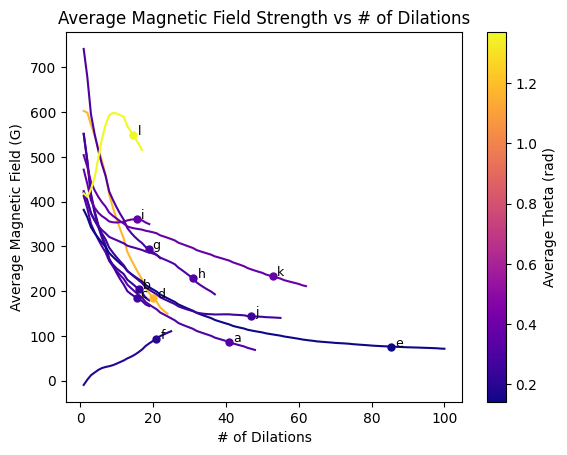

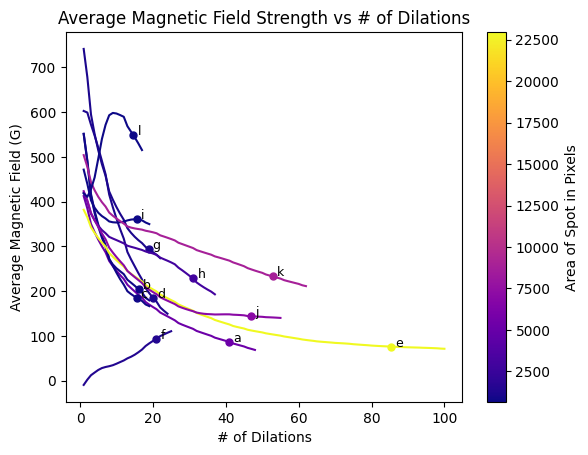

trying to plot...
0.31028044
0.23467857
0.2672806
1.1738589
0.14276329
0.19448027
0.2973504
0.30961758
0.37205675
0.25415817
0.37406388
1.3683301


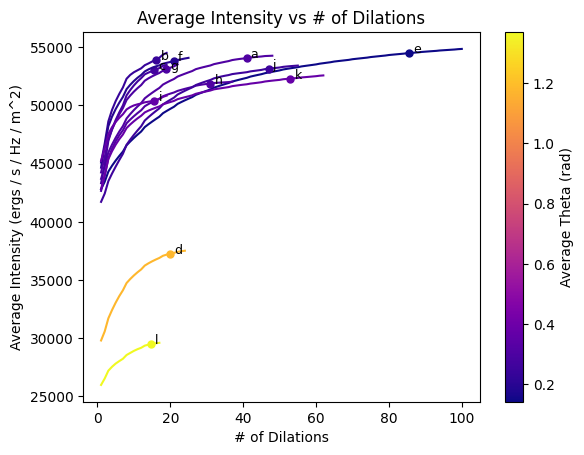

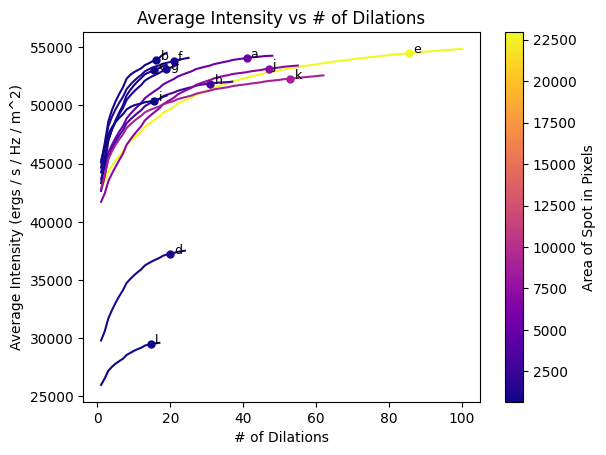

len moat pixels= 4096
shape moat pixels= (4096, 4096)
moat pixels
	 >>> Epoch 2014-01-07T00:00:00 run successfully


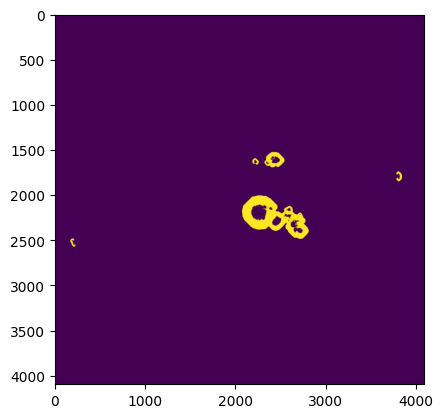

In [23]:
moat_vels = []
moat_mags = []
moat_ints = []
moat_dilations = []
moat_areas = []
moat_thetas = []
moat_vals = []
counter = -1
moat_avg_vels = []
symbol = []

for i in range (3, 5):
    # define the paths where files live
    con_file = os.path.join(data_dir, con_files[i])
    mag_file = os.path.join(data_dir, mag_files[i])
    dop_file = os.path.join(data_dir, dop_files[i])
    aia_file = os.path.join(data_dir, aia_files[i])
    print(data_dir)

    # create the SDOImage object instances
    con = SDOImage(con_file)     # continuum, Relative HMI continuum intensity
    mag = SDOImage(mag_file)     # magnetogram, magnetic field strength
    dop = SDOImage(dop_file)     # Dopplergram, LOS velocity
    aia = SDOImage(aia_file)     # AIA 1700 continuum filtergram, Relative 1700 Angstrom Continuum Intensity


    process_data_set(
    con_file, mag_file, dop_file, aia_file,     
    moat_vels, moat_mags, moat_ints, moat_dilations,  
    moat_thetas, moat_areas, moat_vals, counter,       
    moat_avg_vels, symbol,                    
    mu_thresh=0.1,                            
    n_rings=10,
    suffix=None,
    datadir=data_dir)

    # # do the coordinate transforms, etc.
    # dop.calc_geometry()
    # con.inherit_geometry(dop)
    # mag.inherit_geometry(dop)

    # aia.rescale_to_hmi(con) # reproject onto plate scale of HMI images

    # # calculate the limb darkening correction
    # con.calc_limb_darkening()
    # aia.calc_limb_darkening()

    # # correct magnetogram for foreshortening
    # mag.correct_magnetogram()

    # # calculate differential rot., meridional circ., obs. vel, grav. redshift, cbs
    # dop.correct_dopplergram(fit_cbs=False)

    # # set values to nan for mu less than mu_thresh
    # mu_thresh = 0.1
    # con.mask_low_mu(mu_thresh)
    # dop.mask_low_mu(mu_thresh)
    # mag.mask_low_mu(mu_thresh)
    # aia.mask_low_mu(mu_thresh)

    # counter += 1

    # mask = SunMask(con, mag, dop, aia, moat_vels, moat_mags, moat_ints, moat_dilations, moat_thetas, moat_areas, moat_vals, counter, moat_avg_vels, symbol)
    # mask.mask_low_mu(mu_thresh)

    # label_moats_on_sun(mask)

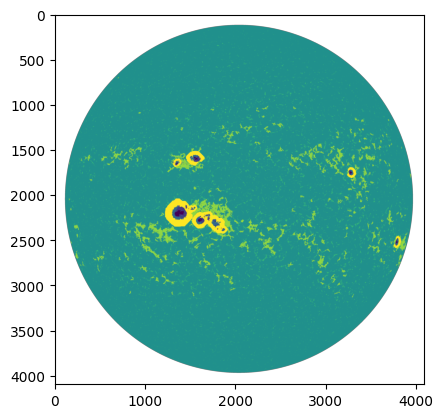

In [6]:
#plot_mask(mask)
plt.imshow(mask.regions)
